<h2 style='color: orange'>Équipe: Louis & Emire</h2>

# Index

1. [Régression linéaire vs DNN](./projet_tp6_rg_dnn_louis_emire.ipynb)
2. [Régression linéaire vs Auto-Encodeur](./projet_tp6_rg_ae_louis_emire.ipynb)
3. [PCA 2D & Auto-Encodeur](./projet_tp6_pca2d_ae_louis_emire.ipynb)

#### B. Pour la régression entre la régression linéaire et un Auto-Encodeur, quelle méthode fonctionne le mieux et pourquoi?


In [309]:
# Librairies
import matplotlib.pyplot as plt
import numpy as np
import torch
import itertools
import sys
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix
from utils.DataSet import DataSet

# Adding initial project root to path

path_to_module = '../'

# Add this path to sys.path
if path_to_module not in sys.path:
    sys.path.insert(0, path_to_module)

import common.engines as engines

In [310]:
# Data importation and pre-processing

data_set = DataSet('./data/TCGA_TPM_hv_subset.h5')

figures_directory = "./figures/project"

data = data_set.get_data('data', float)

genes = data_set.get_data('cols', str)
labels = data_set.get_data('labels', str)
rows = data_set.get_data('rows', str)

Text(0.5, 0.92, 'Ridge classifier vs DNN Auto-Encoder performance analysis on classification of cancer type in TCGA data')

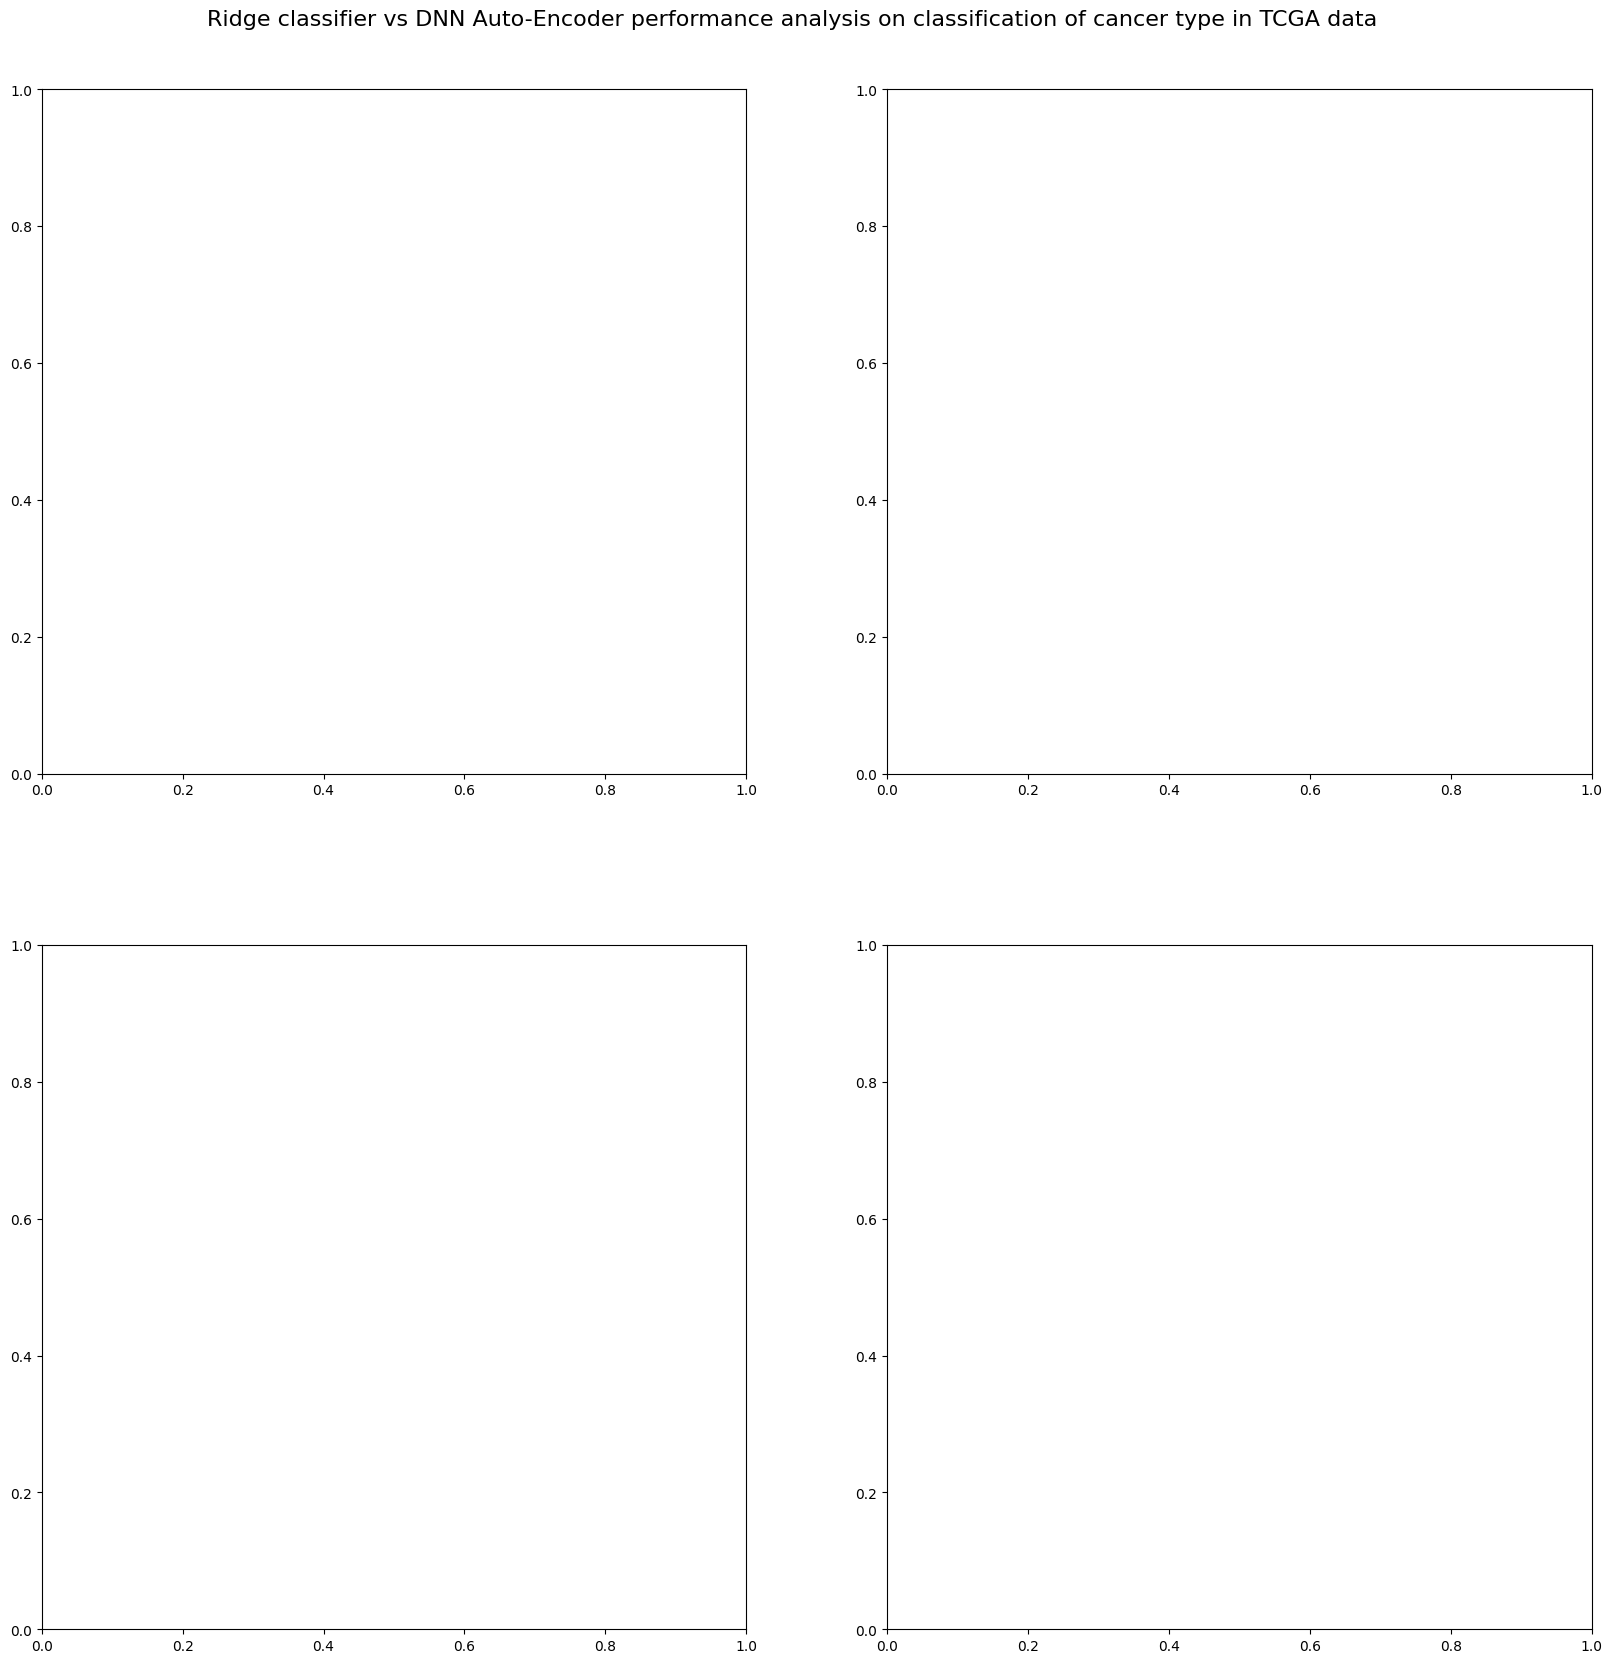

In [302]:
fig, axs = plt.subplots(2, 2, figsize = (20, 20))
fig.subplots_adjust(hspace=0.25)
fig.suptitle('Ridge classifier vs DNN Auto-Encoder performance analysis on classification of cancer type in TCGA data',
              fontsize=16, y=0.92)

#### Régression Logistique

In [303]:
max_iter = 100
X_train, X_test, Y_train, Y_test = train_test_split(data.T, labels, test_size= 0.2)
log_clf = RidgeClassifier(alpha=1e-4, solver ="lsqr", max_iter = max_iter)
log_clf.fit(X_train, Y_train)

train_set_accuracy = round((np.mean(log_clf.predict(X_train) == Y_train)), 2) * 100
test_set_accuracy = round((np.mean(log_clf.predict(X_test) == Y_test)), 2) * 100

print(f"Accuracy on train set (n = {X_train.shape[0]}): {train_set_accuracy}%")
print(f"Accuracy on test set (n = {X_test.shape[0]}): {test_set_accuracy}%")
print(f"Number of errors : {(np.sum(log_clf.predict(X_test) != Y_test)) }")

Accuracy on train set (n = 8276): 100.0%
Accuracy on test set (n = 2070): 96.0%
Number of errors : 83


Confusion matrix

In [304]:
cm = confusion_matrix(log_clf.predict(X_test),  Y_test)

axs[0,0].imshow(cm, cmap='Oranges', vmin=cm.min(), vmax=cm.max())
axs[0,0].set_xticks(np.arange(len(np.unique(labels))), labels = np.unique(labels), rotation = 45, ha='right')
axs[0,0].set_yticks(np.arange(len(np.unique(labels))), labels = np.unique(labels))
axs[0,0].set_xlabel("Predicted Labels", fontsize=12)
axs[0,0].set_ylabel("True Labels", fontsize=12)
axs[0,0].set_title("Ridge classifier confusion matrix on test set", fontsize=14)

thresh = cm.max() / 1.5

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if cm[i, j] != 0:
        axs[0,0].text(j, i, "{:,}".format(cm[i, j]),
        horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")

Errors plot


In [305]:
# Get predictions
predictions = log_clf.predict(X_test)

# Find indices where predictions and actual values differ
error_indices = np.where(predictions != Y_test)[0]

# Adjust this based on your actual data
axs[1,0].scatter(X_test[error_indices, 0], X_test[error_indices, 1], color='orange', label='Errors')

# Optionally, plot correct predictions for comparison
correct_indices = np.where(predictions == Y_test)[0]
axs[1,0].scatter(X_test[correct_indices, 0], X_test[correct_indices, 1], color='#4B0082', alpha=0.5, label='Correct')

axs[1,0].set_xlabel('RC 1', fontsize=12)
axs[1,0].set_ylabel('RC 2', fontsize=12)
axs[1,0].set_title(f'Ridge classifier errors plot on test set\nAccuracy : {test_set_accuracy}%, Iters = {max_iter}', fontsize=14)
axs[1,0].legend()

#### Auto-Endcoder

In [311]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [312]:
mm,encoder  = engines.auto_encoder(insize, insize, 2)
encoder(X_train).shape
mm.parameters()

<generator object Module.parameters at 0x7f5003179af0>

In [313]:
mm, tr_losses, tst_losses, tr_accs, tst_accs  = engines.train_auto_encoder(insize, 2, X_train, X_test, nepochs = 1000, lr = 5 * 1e-4)

Loss 0 Train - loss : 1.0 - acc : 0.005 Test acc : 0.005
Loss 10 Train - loss : 0.919 - acc : 0.123 Test acc : 0.123
Loss 20 Train - loss : 0.83 - acc : 0.255 Test acc : 0.255
Loss 30 Train - loss : 0.619 - acc : 0.369 Test acc : 0.369
Loss 40 Train - loss : 0.311 - acc : 0.641 Test acc : 0.641
Loss 50 Train - loss : 0.176 - acc : 0.801 Test acc : 0.801


Learning curves

In [ ]:
axs[1, 1].cla()

markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])

steps = np.arange(len(tr_losses))

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='orange', lw=2, linestyle='--'),
                Line2D([0], [0], color='purple', lw=2, linestyle='--')]

# First plot (Losses) on axs[0, 1]
axs[1, 1].plot(steps, tr_losses, label="train (loss)", color='green')
axs[1, 1].plot(steps, tst_losses, label="test (loss)", color='blue')
axs[1, 1].plot(steps[-1], tr_losses[-1], 'go', markersize=5, label=f'({steps[-1]}, {tr_losses[-1]:.2f})')
axs[1, 1].plot(steps[-1], tst_losses[-1], 'bv', markersize=5, label=f'({steps[-1]}, {tst_losses[-1]:.2f})')
axs[1, 1].set_ylabel("Cross entropy loss", fontsize=12)
axs[1, 1].set_xlabel("Epochs number", fontsize=12)
axs[1, 1].legend(loc='center right', bbox_to_anchor=(1, 0.575))

# Second plot (Accuracies) on the same subplot, but using a secondary y-axis
sec_ax = axs[1, 1].twinx()
sec_ax.plot(steps, tr_accs * 100, label="train (accuracy)", color='orange')
sec_ax.plot(steps, tst_accs * 100, label="test (accuracy)", color='purple')
sec_ax.plot(steps[-1], tr_accs[-1] * 100, 'o', color='orange', markersize=5, label=f'({steps[-1]}, {tr_accs[-1]*100:.2f}%)')
sec_ax.plot(steps[-1], tst_accs[-1] * 100, 'v', color='purple', markersize=5, label=f'({steps[-1]}, {tst_accs[-1]*100:.2f}%)')
sec_ax.set_ylabel("Accuracy (%)", fontsize=12)
sec_ax.set_ylim((0, 102))
sec_ax.legend(loc='center right', bbox_to_anchor=(1, 0.425))

# Set the title for the combined plot
axs[1, 1].set_title(f"Learning curves of DNN\nN={data.T.shape[1]}, N(train)={X_train.shape[0]}, N(test)={X_test.shape[0]}", fontsize=14)